In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Group B

- Consolee MURAGIJIMANA
- Dhorasso Junior TEMFACK NGUEFACK
- Isaac Oluwasegun ADENIYI

# Model formulation and discretization

The model that we want to simulate is given by:
\begin{align}
\begin{cases}
m\ddot{x} &= -G\dot{x} + F_x + F_{x,E} \\
m\ddot{y} &= -G\dot{y} + F_y + F_{y,E} \\
\tau \dot{F_x} &= u_x - F_x \\
\tau \dot{F_y} &= u_y - F_y \\
\dot{F_{x,E}} &= 0 \\
\dot{F_{y,E}} &= 0
\end{cases}
\end{align}

Now by addy the target state $(x^* , y^*)$, this system becomes:

\begin{align}
\begin{cases}
m\ddot{x} &= -G\dot{x} + F_x + F_{x,E} \\
m\ddot{y} &= -G\dot{y} + F_y + F_{y,E} \\
\tau \dot{F_x} &= u_x - F_x \\
\tau \dot{F_y} &= u_y - F_y \\
\dot{F_{x,E}} &= 0 \\
\dot{F_{y,E}} &= 0\\
\dot{x^*}&=0\\
\dot{y^*}&=0\\
\end{cases}
\end{align}


and the state vector is $Z=[x,y,\dot{x},\dot{y},F_x,F_y,F_{x,E},F_{y,E},x^*,y^*]^T$

WIth $(x^* , y^*) = (0, 0.2)$ The Target.

- $\textbf{ Transformation in matrix form (Adding the target $(x^*,y^*)$)}$

This system can be write as $\dot{Z}=A_cZ+B_cU$, where

\begin{align}
A_c=\begin{pmatrix}
0&0&1&0&0&0&0&0&0&0\\
0&0&0&1&0&0&0&0&0&0\\
0&0&-G/m&0&1/m&0&1/m&0&0&0\\
0&0&0&-G/m&0&1/m&0&1/m&0&0\\
0&0&0&0&-1/\tau&0&0&0&0&0\\
0&0&0&0&0&-1/\tau&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0\\
\end{pmatrix}
\qquad, 
B_c=\begin{pmatrix}
0&0\\
0&0\\
0&0\\
1/\tau&0\\
0&1/\tau\\
0&0\\
0&0\\
0&0\\
0&0\\
0&0
\end{pmatrix}\
\end{align}

and  $U=[u_x,u_y]^T$

- $\textbf{Discretization}$

By usin Euler interpolation on $\dot{Z}=A_cZ+B_cU$, we get
\begin{align}
Z(t+\delta t)&=Z(t)+\delta t \dot{Z(t)}\\
             &= Z(t)+\delta t (A_cZ(t)+B_cU)\\
             &=(I_{10}+\delta t A_c)X(t)+\delta t B_cU
\end{align}
So we get our discretized system:
$$ Z_{t+1}= AZ_t+BU_t$$

Where $$A=I_{10}+\delta t A_c,\quad B=\delta t B_c \quad \text{ and } \quad U=[u_x,u_y]^T$$

In this system we add a noise $\xi_t$. Then our final system is:
$$ Z_{t+1}= AZ_t+BU_t+\xi_t$$

# Main Code: LQG control model

In this part we generate a function which can solve this Stochastic Optimal Control probem for different shape of the target

In [2]:

def LQG(w1,w2,tf):
    """
    In this function, we implement the LQG in two dimensions 
    including the external forces in the two axis
    w1,w2: parameters to change the sphare of the target
    tf: represent the time where we apply the forces
    :return: The state vector and the feeback gain
    """
    # Simulation parameters and model matrices ---------------------------------------------
    BigZ=[] 
    BigU=[]
    for r in range(20): # repeat the program 20 times:
                        # 10 times without external forces 
                        # 10 times with apply the forces
       
    # Numerical parameters-----------------------------------------------------
        G=0.1        # viscous constant
        m=1          # inertia
        tau=0.08     # muscle time constant
        dt=0.01      # Time step



        # Definition of the matrix A of the system----------------------------------
        
        ## Discrete time
        A=np.zeros((10,10))
        Ac=np.zeros((8,8))
        Ac[0,2]=1
        Ac[1,3]=1
        Ac[2]=[0,0,-G/m,0,1/m,0,1/m,0]
        Ac[3]=[0,0,0,-G/m,0,1/m,0,1/m]
        Ac[4,4]=-1/tau
        Ac[5,5]=-1/tau
        
        ## Augmentation of the system matrices to include the target
        A[0:8, 0:8]=np.identity(8)+ dt*Ac
        A[8:,8:]=np.identity(2)



        # Definition of the matrix B of the system----------------------------------
        Bc=np.zeros((10,2))
        Bc[4,0]=1/tau
        Bc[5,1]=1/tau
        B=dt*Bc

        # Definition of the cost-function -------------------------------------
        w3=4
        w4=4
        ## Definition of the QN matrix
        q1=np.array([[1],[0],[0],[0],[0],[0],[0],[0],[-1],[0]]) # Penality on the x-axis
        q2=np.array([[0],[1],[0],[0],[0],[0],[0],[0],[0],[-1]]) # Penality on the y-axis
        q3=np.array([[0],[0],[1],[0],[0],[0],[0],[0],[0],[0]])  # Penality on the x-velocity
        q4=np.array([[0],[0],[0],[1],[0],[0],[0],[0],[0],[0]])  # Penality on the y-velocity
        QN=w1*q1@q1.T+w2*q2@q2.T+w3*q3@q3.T+w4*q4@q4.T

        S=QN
        N=50
        Z=np.zeros((10,N)) # State vector
        Z[:,0]=[0,0,0,0,0,0,0,0,0,0.2] # Target
        R=10**-5*np.identity(2)
        
        # Backward recurrence to calculate the optimal feedback gains ------------------
        BigL=[]
        for k in range(N):     
            Sigma=0.005*B@B.T                      # Noise covariance matrix
            eps= np.random.multivariate_normal(np.zeros(10), Sigma)
            L=np.linalg.inv(R+B.T@S@B)@B.T@S@A
            BigL.append(L)
            S=A.T@S@(A-B@L)

        u=np.zeros((2,N)) # List of target at each times step
        l=BigL[::-1]   
        
        # Backward recurrence to calculate the state vector ---------------------------
        for k in range(N-1):   
            L=l[k]
            Z[:,k+1]=(A-B@L)@Z[:,k] + eps
            u[:,k]=-L@Z[:,k]
            if k>=tf and r>=10:  # We apply the for at the time tf
                Z[:,k+1][6]=8    # Fx,E
                Z[:,k+1][7]=5    # Fy,E
        BigZ.append(Z)
        BigU.append(u)
    return BigZ,BigU

# Expiemention with diffrents Targets

### Round Target

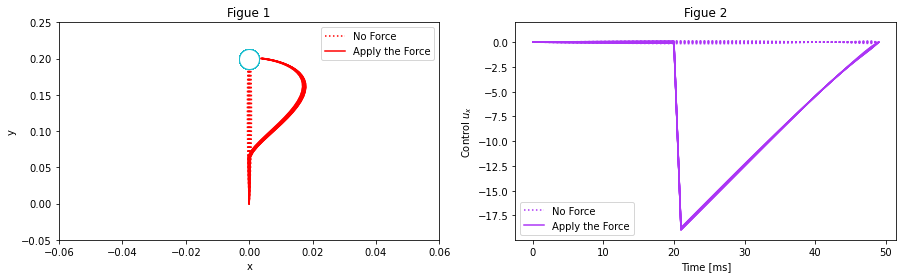

In [3]:
# Parameters for the round target----------------------------------------------------
w1t=20
w2t=20
tf=20

BigZ1,BigU1=LQG(w1t,w2t,tf)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)

# State---------------------------------------------------------------------------------
for r in range(20):
    if r<10:
        plt.plot(BigZ1[r][0],BigZ1[r][1],"r:") # No apply the forces
    else:
        plt.plot(BigZ1[r][0],BigZ1[r][1],"r") # Apply the forces
    plt.plot(BigZ1[r][8,:],BigZ1[r][9,:], marker="o", markersize=20,
             markerfacecolor="white")
    plt.ylim(-0.05,0.25)
    plt.xlim(-0.06,0.06)
    plt.xlabel("x")
    plt.ylabel("y")
plt.plot(1,1,":",color="r",label="No Force")
plt.plot(1,1,color="r",label="Apply the Force")
plt.title("Figue 1")
plt.legend()
plt.subplot(1,2,2)

# control----------------------------------------------------------------------------
for r in range(20):
    if r<10:
        plt.plot(BigU1[r][0],":",color="#ac35f6")  # Control withow apply the forces
    else:
        plt.plot(BigU1[r][0], color= "#ac35f6")    # Control withing apply the forces
    plt.xlabel("Time [ms]")
    plt.ylabel("Control $u_x$")
plt.plot(1,1,":",color="#ac35f6",label="No Force")
plt.plot(1,1,color="#ac35f6",label="Apply the Force")
plt.title("Figue 2")
plt.legend()
plt.show()

## Interpretation:

Figure $1$ shows the experience where the task is to reach the round target placed at $20cm$ along the y axis, and Figure $2$ shows the feedback correction at each timed step along the x axis. The dot lines in both figures represents the simulation without the external forces, while the solid lines represent the situation when the external forces, and are applied by a rebot at $t_{f}=20ms$. 

It is glary that without the forces, the direction is almost a straight line, but when we apply the pertubation, we have a deviation before reaching the target. By looking at the graph of the control (Figure $2$), we can see that when we don't apply the force, the control is almost zero, and when the force is applied, the amplitude of the control is very high ($u_{x_{\max}}\approx 20$). The minus sign in the contol is due to the direction where we apply the force.

## Long Target

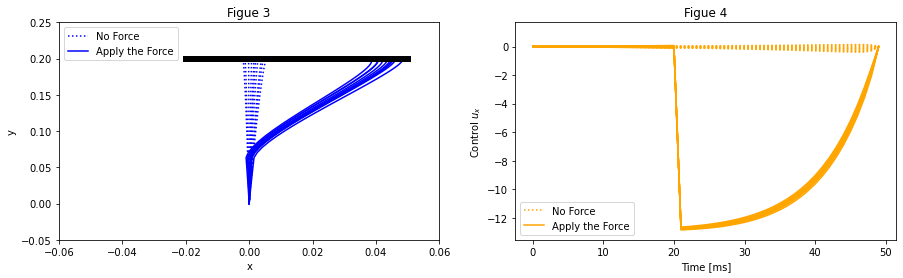

In [4]:
# Parameters for the long target----------------------------------------------------
w1=0
w2=10
tf=20

BigZ,BigU=LQG(w1,w2,tf)
Z_est=BigZ[10][6]-np.random.normal(0,0.25,50)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)

#State--------------------------------------------------------------------------
for r in range(20):
    if r<10:
        plt.plot(BigZ[r][0],BigZ[r][1],"b:") # No apply the forces
    else: 
        plt.plot(BigZ[r][0],BigZ[r][1],"b")  # No apply the forces
    plt.plot([-0.02,0.05],[BigZ[r][9,:][0],BigZ[r][9,:][0]],"k",lw=6)
    plt.ylim(-0.05,0.25)
    plt.xlim(-0.06,0.06)
    plt.xlabel("x")
    plt.ylabel("y")
plt.plot(1,1,":",color="b",label="No Force")
plt.plot(1,1,color="b",label="Apply the Force")
plt.title("Figue 3")
plt.legend()
plt.subplot(1,2,2)

#Control-------------------------------------------------------------------------
for r in range(20):
    if r<10:
        plt.plot(BigU[r][0],":",color="orange") # Control withow apply the forces
    else:
        plt.plot(BigU[r][0],"orange")           # Control withing apply the forces
    plt.xlabel("Time [ms]")
    plt.ylabel("Control $u_x$")
plt.plot(1,1,":",color="orange",label="No Force")
plt.plot(1,1,color="orange",label="Apply the Force")
plt.title("Figue 4")
plt.legend()
plt.show()

## Interpretation:

Figure $3$ shows the experience where the task is to reach the long target placed at $20cm$ along the $y$ axis, and Figure $4$ shows the control vector at each time step. The dot lines in both figures represent the simulation without the external forces, while the solid lines represent the situation when the external forces are applied at $t_{f}=20ms$. 

It is then glary that without the forces, the direction is almost a straight line, but when we apply the pertubation, we have a large deviation before reaching the target. As in the previous case, we can also see that when we don't apply the force, the control is almost zero, and when the force is applied, the amplitude of the control is very high ( $u_{x_{\max}}\approx 12$ in Figure $4$). The minus sign in the contol is due to the direction where we apply the force.

# Comparison of the two Targets

In this part we do the comparison between the feeback gain of the two differents targets

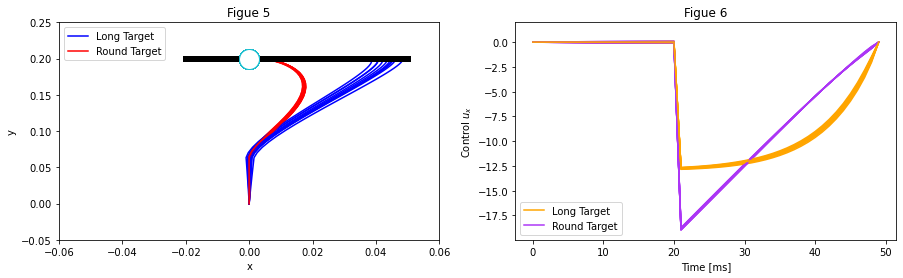

In [5]:
# Superposition of the two case--------------------------------------------------
# when we apply the forces--------------------------------------------------------
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)

# State-----------------------------------------------------------------------
for r in range(10,20):
    plt.plot(BigZ[r][0],BigZ[r][1],"b")    # State for Long Target
    plt.plot(BigZ1[r][0],BigZ1[r][1],"r")  # State for Round Target
    plt.plot([-0.02,0.05],[BigZ[r][9,:][0],BigZ[r][9,:][0]],"k",lw=6)  # Long Target
    plt.plot(BigZ[r][8,:],BigZ1[r][9,:], marker="o", markersize=20, markerfacecolor="white") # Round Target
    plt.ylim(-0.05,0.25)
    plt.xlim(-0.06,0.06)
    plt.xlabel("x")
    plt.ylabel("y")
plt.plot(1,1,color="b",label="Long Target")
plt.plot(1,1,color="r",label="Round Target")
plt.title("Figue 5")
plt.legend()


plt.subplot(1,2,2)

# Control for the two targets-------------------------------------------------------------------------------
for r in range(10,20):
    plt.plot(BigU1[r][0],"#ac35f6")
    plt.plot(BigU[r][0],"orange")
    plt.xlabel("Time [ms]")
    plt.ylabel("Control $u_x$")

plt.plot(1,1,color="orange",label="Long Target")
plt.plot(1,1,color="#ac35f6",label="Round Target")
plt.title("Figue 6")
plt.legend()
plt.show()

## Interpretation:

Figure $5$ shows the superposition of the two experiences (the experience for the round target in red and the experience for the long target in blue). Figure $6$ shows the comparison between the feedback corrections applied for the two targets. Each of those experience is repeated 10 times.

In Figure $6$, we can easily see that in the case of the round target (violet color), the amplitude of the control is more larger than in the case of the long target (orange color). This is normal because to reach the round target, which is small, we need to apply more control than the long target, where the surface to reach is larger and we can reach any point on the bar.

### Target and Target estimate

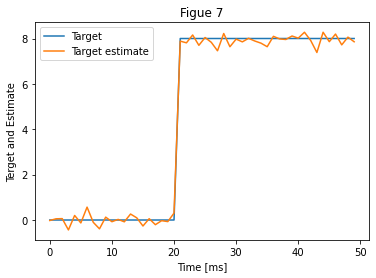

In [9]:
plt.plot(BigZ[10][6],label="Target")    # Target
plt.plot(Z_est,label="Target estimate")  #  Target estimate
plt.xlabel('Time [ms]')
plt.ylabel('Terget and Estimate')
plt.title("Figue 7")
plt.legend()
plt.show()

The plot above showns the target state and the estimated target state by the Kalman filter.The estimate of the target state goes faster to the novel value after the target jump.


### Plot of velocity

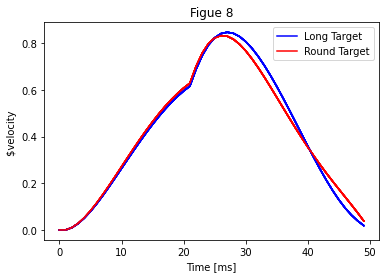

In [7]:
# Velocity plot-----------------------------------------------------------------
V=(BigZ[r][2]**2+BigZ[r][3]**2)**0.5       # Velocity for the round target
V1=(BigZ1[r][2]**2+BigZ1[r][3]**2)**0.5    # Velocity for the long target
## x-velocity------------------------------
for r in range(10,20):
    plt.plot(V,"b")    
    plt.plot(V1,"r")  
    plt.xlabel('Time [ms]')
    plt.ylabel("$velocity ")
plt.plot(0,0,color="b",label="Long Target")
plt.plot(0,0,color="r",label="Round Target")
plt.title("Figue 8")
plt.legend()
plt.show()

The plot above show us the evolution of the volocity when we apply the force. We can see that when we apply the force at time $t_f=20ms$, The velocity increase at reach his maximum in order to reach the target. We also see that the velocity for the two target his almost the same, which means tghat the velocity does'nt depend on the shape of the target.